In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
plt.rcParams["figure.figsize"] = (15,4)

In [3]:
RECORDING_DIR = "recordings"
WIO_TERMINAL_FILE = "wio_terminal_dataset_28_29_30_oct.xlsx"
MECH_READINGS_FILE = "mechanical_sensor_2.csv"
SOUND_READINGS_FILE = "sound_sensor_2.csv"

In [4]:
mech_cols = ["date", "time", "ntipps", "rainfall (mm)"]
mech_cols_desired = ["datetime", "ntipps", "rainfall (mm)"]
sound_cols = ["date", "time", "sound", "loudness"]
sound_cols_desired = ["datetime", "sound", "loudness"]
wio_cols_desired = ["time", "wio_sound"]

In [5]:
wio_file_path = join(RECORDING_DIR, WIO_TERMINAL_FILE)
wio_data = pd.read_excel(wio_file_path, names=wio_cols_desired)

mech_file_path = join(RECORDING_DIR, MECH_READINGS_FILE)
mech_data = pd.read_csv(mech_file_path, names=mech_cols)

sound_file_path = join(RECORDING_DIR, SOUND_READINGS_FILE)
sound_data = pd.read_csv(sound_file_path, names=sound_cols)

In [6]:
cutoff_value = 0.0

In [7]:
def process_mech_data(df):
    df["datetime"] = df["date"]+" "+df["time"]
    df["datetime"] = pd.to_datetime(df["datetime"])
    df = df.drop(["date", "time"], axis=1)
    df = df[mech_cols_desired]
    df["rainfall (mm)"] = df["rainfall (mm)"].str.split(" ").str[1]
    df["rainfall (mm)"] = df["rainfall (mm)"].astype(float)
    df = df[df["rainfall (mm)"]>cutoff_value]
    return df

In [8]:
def process_sound_data(df):
    df["time"] = df["time"].str.split(":").str[:-1].str.join(":")
    df["date"] = df["date"].str.split("/").str[::-1].str.join("-")
    df["datetime"] = df["date"]+" "+df["time"]
    df["datetime"] = pd.to_datetime(df["datetime"])
    df = df.drop(["date", "time"], axis=1)
    df = df[sound_cols_desired]
    df["sound"] = df["sound"].astype(float)
    df["loudness"] = df["loudness"].astype(float)
    return df

In [9]:
mech_data = process_mech_data(mech_data)
sound_data = process_sound_data(sound_data)

/tmp/ipykernel_59414/2306343243.py:5: UserWarning: Parsing dates in %d-%m-%Y  %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["datetime"] = pd.to_datetime(df["datetime"])


In [10]:
mech_data

,datetime,ntipps,rainfall (mm)
11,2023-10-27 17:43:00,1,0.2
19,2023-10-27 17:51:00,3,0.6
34,2023-10-27 18:06:00,1,0.2
1056,2023-10-28 11:08:00,6,1.2
1058,2023-10-28 11:10:00,6,1.2
1059,2023-10-28 11:11:00,2,0.4


In [11]:
wio_data.to_csv(join(RECORDING_DIR, "wio_data.csv"), index=False)

In [12]:
timepoints = list(set(sound_data["datetime"]).intersection(mech_data["datetime"]))
sound_data = sound_data.loc[sound_data["datetime"].isin(timepoints)]
mech_data = mech_data.loc[mech_data["datetime"].isin(timepoints)]

In [13]:
data_merged = pd.merge(mech_data, sound_data, on="datetime", how="inner")

In [14]:
data_merged = pd.merge(mech_data, sound_data, on="datetime", how="inner")
data_merged['timedelta'] = (data_merged["datetime"]-data_merged["datetime"].shift()).fillna(pd.Timedelta(0))
data_merged["timedelta_min"] = data_merged["timedelta"].dt.total_seconds().div(60).astype(int)

Text(0.5, 1.0, 'Rainfall vs. loudness scatter plot')

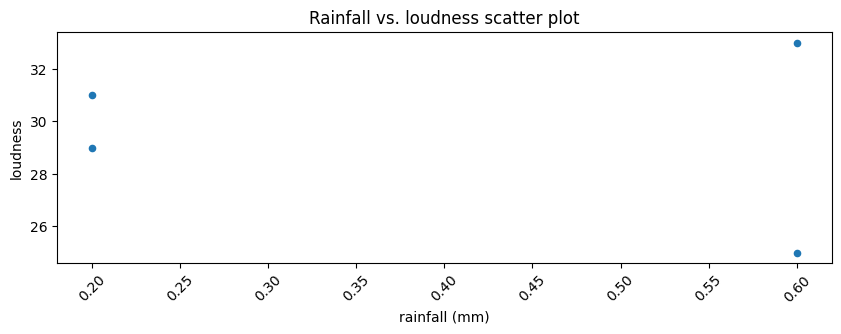

In [15]:
data_merged.plot(x="rainfall (mm)", y="loudness", kind='scatter', rot=45, figsize=(10,3))
plt.title("Rainfall vs. loudness scatter plot")

In [16]:
data_merged

,datetime,ntipps,rainfall (mm),sound,loudness,timedelta,timedelta_min
0,2023-10-27 17:43:00,1,0.2,63.0,31.0,0 days 00:00:00,0
1,2023-10-27 17:51:00,3,0.6,116.0,25.0,0 days 00:08:00,8
2,2023-10-27 17:51:00,3,0.6,64.0,33.0,0 days 00:00:00,0
3,2023-10-27 18:06:00,1,0.2,60.0,29.0,0 days 00:15:00,15


In [17]:
data_merged.corr(method='spearman')

,datetime,ntipps,rainfall (mm),sound,loudness,timedelta,timedelta_min
datetime,1.000000,0.000000,0.000000,-0.316228,-0.316228,0.833333,0.833333
ntipps,0.000000,1.000000,1.000000,0.894427,0.000000,-0.235702,-0.235702
rainfall (mm),0.000000,1.000000,1.000000,0.894427,0.000000,-0.235702,-0.235702
sound,-0.316228,0.894427,0.894427,1.000000,-0.200000,-0.316228,-0.316228
loudness,-0.316228,0.000000,0.000000,-0.200000,1.000000,-0.737865,-0.737865
timedelta,0.833333,-0.235702,-0.235702,-0.316228,-0.737865,1.000000,1.000000
timedelta_min,0.833333,-0.235702,-0.235702,-0.316228,-0.737865,1.000000,1.000000


In [18]:
wio_data.head(5)

,time,wio_sound
0,00:04:49,441
1,00:04:49,419
2,00:04:49,389
3,00:04:50,383
4,00:04:50,398


In [19]:
wio_data["time"] = pd.to_datetime(wio_data["time"], format="%H:%M:%S")

In [20]:
# wio_data = wio_data.sort_values(by="time")

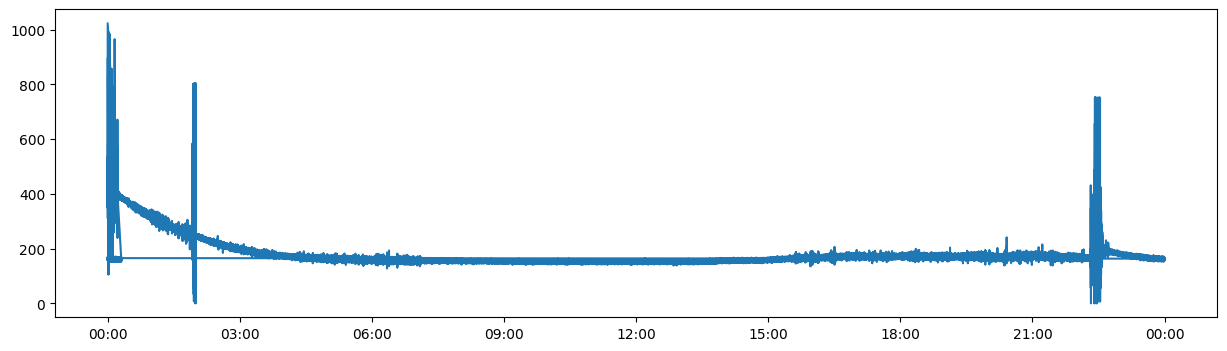

In [21]:
plt.plot(wio_data["time"], wio_data["wio_sound"])
xformatter = mdates.DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

In [22]:
wio_data

,time,wio_sound
0,1900-01-01 00:04:49,441
1,1900-01-01 00:04:49,419
2,1900-01-01 00:04:49,389
3,1900-01-01 00:04:50,383
4,1900-01-01 00:04:50,398
...,...,...
525167,1900-01-01 00:01:17,489
525168,1900-01-01 00:01:17,448
525169,1900-01-01 00:01:17,472
525170,1900-01-01 00:01:17,482
